In [103]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [355]:
'''
Loading
'''

atlas = nice.graph.graph_from_json('Data/atlas.json')
reduced_atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')
corridor_atlas = nice.graph.graph_from_json('Data/corridor_atlas.json')

state = gpd.read_file('Data/Geometry/california.shp')
counties = gpd.read_file('Data/Geometry/california_counties.shp')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

In [545]:
places = nice.graph.graph_from_json('Data/places.json')

In [546]:
places.number_of_nodes()

468

In [ ]:
reduced_atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

In [552]:
d = {k: {**n} for k, n in reduced_atlas._node.items()}
# d = {**d, **{k: {'x': n['x'], 'y': n['y']} for k, n in places._node.items()}}
df = pd.DataFrame.from_dict(d, orient = 'index')
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y), crs = 4326)
gdf = gdf.to_crs(2163)

In [553]:
from sklearn.cluster import DBSCAN, KMeans

xy = [[r.geometry.centroid.x, r.geometry.centroid.y] for idx, r in gdf.iterrows()]

# clustering = DBSCAN(eps = 5e3, min_samples = 1).fit(xy)
clustering = KMeans(n_clusters = 300).fit(xy)

clustering

KMeans(n_clusters=300)

In [554]:
df['cluster'] = clustering.labels_

x = df['x'].to_numpy()
y = df['y'].to_numpy()
i = df.index.to_numpy()
c = clustering.labels_

node_map = {i: r['cluster'] for i, r in df.iterrows()}

cluster_map = {k: i[c == k] for k in np.unique(c)}
cluster_map

nodes = []

for k, v in cluster_map.items():

    node = {
        'x': np.mean([reduced_atlas._node[n]['x'] for n in v]),
        'y': np.mean([reduced_atlas._node[n]['y'] for n in v]),
    }

    nodes.append((k, node))

r_a_edges = list(reduced_atlas.edges)
k = list(cluster_map.keys())

_adj = {s: {t: {'time': [], 'distance': []} for t in k} for s in k}

for edge in r_a_edges:

    s, t = edge

    # print(reduced_atlas._adj[s][t])

    # _adj['time'].append(reduced_atlas._adj[s][t]['speed'])
    _adj[node_map[s]][node_map[t]]['distance'].append(
        reduced_atlas._adj[s][t]['distance']
    )

    _adj[node_map[s]][node_map[t]]['time'].append(
        reduced_atlas._adj[s][t]['time']
    )

edges = []

for s in k:
    for t in k:
        if _adj[s][t]['time'] != []:

            edges.append(
                (
                    s, t,
                    {
                        'time': np.mean(_adj[s][t]['time']),
                        'distance': np.mean(_adj[s][t]['distance']),
                        'speed': (
                            np.mean(_adj[s][t]['distance']) /
                            np.mean(_adj[s][t]['time'])
                        )
                    }
                )
            )

g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

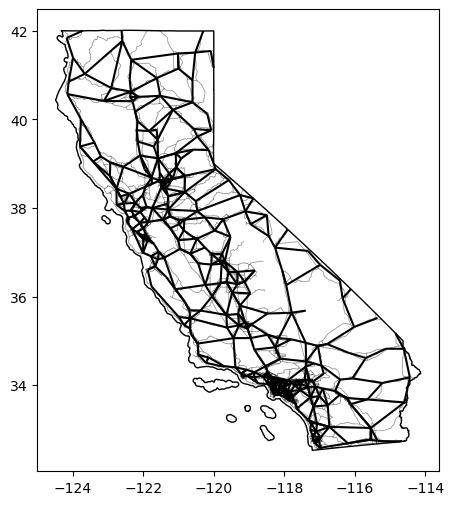

In [555]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)

kw = {
    # 'field': 'time',
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    # 'field': 'speed',
    # 'colorbar': {},
    'plot': {
        'zorder': 1,
        'color': 'k',
        # 'lw': .5,
        # 'alpha': .25,
    },
}

_ = nice.plot.plot_edges(g, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 35,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'Large Cities',
    },
}

# _ = nice.plot.plot_nodes(places, ax, **kw)

In [536]:
175 / 1.6, 9000 / 3600

(109.375, 2.5)

In [477]:
df_c = df.groupby('cluster', as_index = False).mean()
gdf_c = gpd.GeoDataFrame(
    df_c, geometry = gpd.points_from_xy(df_c.x, df_c.y), crs = 4326
)
gdf_c.shape

(300, 4)

<Axes: >

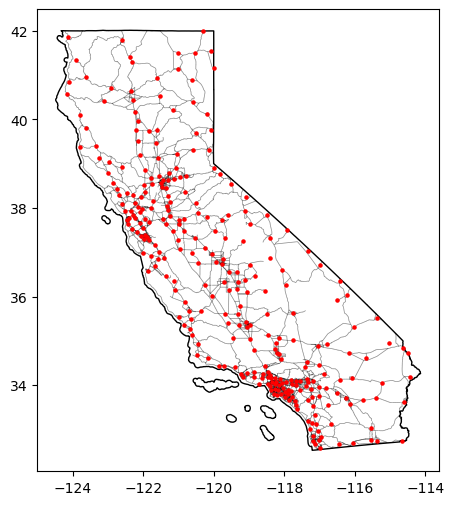

In [478]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)

kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    # 'column': 'cluster',
    'markersize': 5,
    'color': 'r',
}

gdf_c.plot(ax = ax, **kw)

In [479]:
nodes = [(i, {'x': r['x'], 'y': r['y']}) for i, r in df_c.iterrows()]

g = nx.Graph()
g.add_nodes_from(nodes)

In [490]:
deep_reload(nice)

graph_to_atlas, atlas_to_graph = nice.graph.node_assignment(
    reduced_atlas, g
)

g_r = nice.graph.reduction(
    reduced_atlas,
    origins = [graph_to_atlas[n] for n in g.nodes],
    # maximum_cost = 100e3,
    include_intersections = False,
    snowball = False,
)

276one, 299 in queue                 
276one, 298 in queue                 
276one, 297 in queue                 
276one, 296 in queue                 
276one, 295 in queue                 
276one, 294 in queue                 
276one, 293 in queue                 
276one, 292 in queue                 
276one, 291 in queue                 
276one, 290 in queue                 
276done, 289 in queue                 
276done, 288 in queue                 
276done, 287 in queue                 
276done, 286 in queue                 
276done, 285 in queue                 
276done, 284 in queue                 
276done, 283 in queue                 
77 done, 282 in queue                 
276done, 281 in queue                 
276done, 280 in queue                 
276done, 279 in queue                 
276done, 278 in queue                 
276done, 277 in queue                 
276done, 276 in queue                 
276done, 275 in queue                 
276done, 274 in queue              

KeyboardInterrupt: 

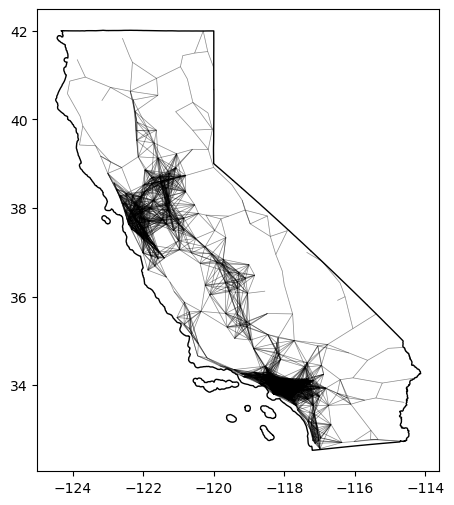

In [488]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)


kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(g_r, ax, **kw)

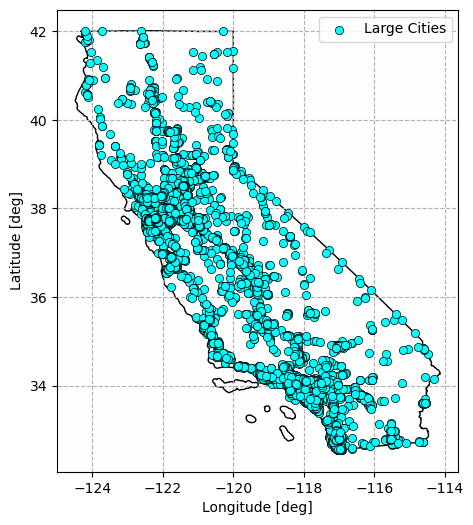

In [397]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)


kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

# _ = nice.plot.plot_edges(reduced_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1.5,
        'alpha': 1,
        'label': '5-99 Corridor',
    },
}

# _ = nice.plot.plot_edges(corridor_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 35,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'Large Cities',
    },
}

_ = nice.plot.plot_nodes(reduced_atlas, ax, **kw)

kw = {
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/places_corridor.png', bbox_inches = 'tight', dpi = 300
# )

In [341]:
sum([n.get('population', 0) for n in graph_all._node.values()])

19784197.0

In [342]:
5e5 * 24 / 19784197.0

0.6065447083851824

In [342]:
19784197.0

0.6065447083851824

In [211]:
places_50k = nice.graph.graph_from_json('Data/places_50k.json')

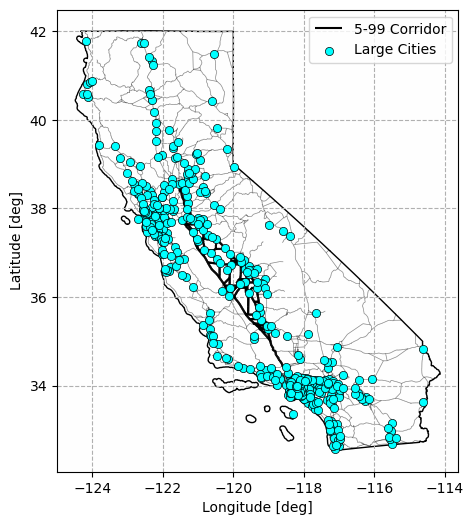

In [353]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)


kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1.5,
        'alpha': 1,
        'label': '5-99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 35,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'Large Cities',
    },
}

_ = nice.plot.plot_nodes(places, ax, **kw)

kw = {
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/places_corridor.png', bbox_inches = 'tight', dpi = 300
# )

In [217]:
ccs_stations = nice.graph.subgraph(
    graph_ccs, [k for k in graph_ccs.nodes if 'station' in k]
)

nacs_stations = nice.graph.subgraph(
    graph_nacs, [k for k in graph_nacs.nodes if 'station' in k]
)

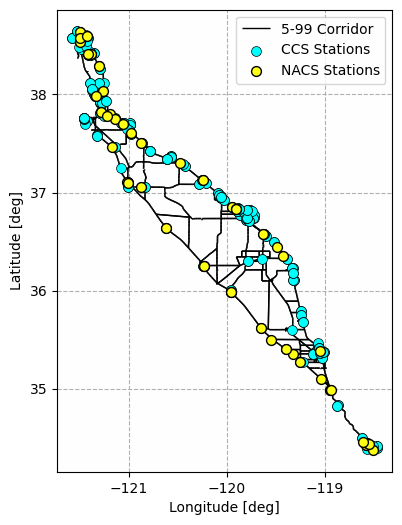

In [318]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1,
        'alpha': 1,
        'label': '5-99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 50,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'CCS Stations',
    },
}

_ = nice.plot.plot_nodes(ccs_stations, ax, **kw)

kw = {
    'plot': {
        'zorder': 4,
        's': 50,
        'fc': 'xkcd:yellow',
        'ec': 'k',
        'lw': 1,
        'label': 'NACS Stations',
    },
}

_ = nice.plot.plot_nodes(nacs_stations, ax, **kw)

kw = {
    'xlabel': 'Longitude [deg]',
    'xticks': [-121, -120, -119],
    'ylabel': 'Latitude [deg]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

ax.set_aspect('equal')

# fig.savefig(
#     'Paper/figures/places_corridor.png', bbox_inches = 'tight', dpi = 300
# )

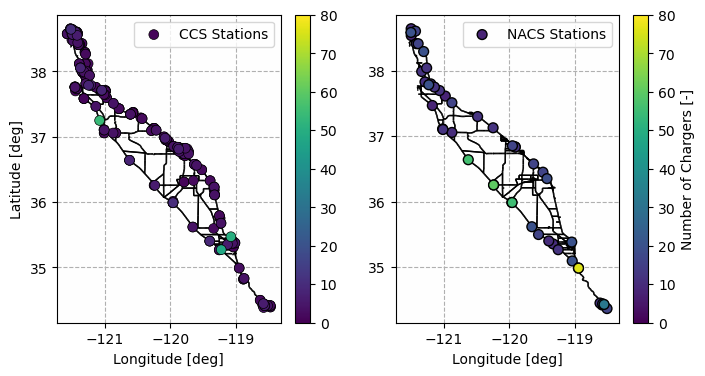

In [319]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1,
        'alpha': 1,
        # 'label': 'I5-CA99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax[0], **kw)
_ = nice.plot.plot_edges(corridor_atlas, ax[1], **kw)

kw = {
    'field': 'port_count',
    'colorbar': {},
    'plot': {
        'zorder': 3,
        's': 50,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'CCS Stations',
        'vmin': 0,
        'vmax': 80,
    },
}

_ = nice.plot.plot_nodes(ccs_stations, ax[0], **kw)

kw = {
    'field': 'port_count',
    'colorbar': {
        'label': 'Number of Chargers [-]',
    },
    'plot': {
        'zorder': 4,
        's': 50,
        'fc': 'xkcd:yellow',
        'ec': 'k',
        'lw': 1,
        'label': 'NACS Stations',
        'vmin': 0,
        'vmax': 80,
    },
}

_ = nice.plot.plot_nodes(nacs_stations, ax[1], **kw)

ax[0].set_ylabel('Latitude [deg]')

kw = {
    'xlabel': 'Longitude [deg]',
    'xticks': [-121, -120, -119],
    'facecolor': '#fefefe',
    # 'ylabel': 'Latitude [deg]',
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

_ = [ax.legend() for ax in ax]

_ = [ax.set_aspect('equal') for ax in ax]

fig.savefig(
    'Paper/figures/stations_corridor.png', bbox_inches = 'tight', dpi = 300
)

In [265]:
ccs_stations.number_of_nodes(), nacs_stations.number_of_nodes()

(344, 47)

In [323]:
np.array([n['port_count'] for n in ccs_stations._node.values()]).sum()

1029

In [324]:
np.array([n['port_count'] for n in nacs_stations._node.values()]).sum()

901

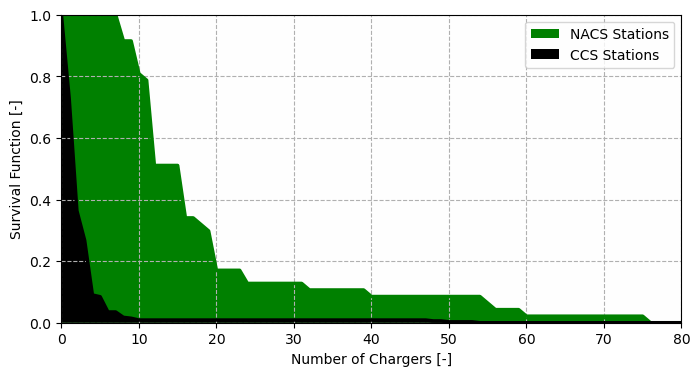

In [320]:
fig, ax = plt.subplots(figsize = (8, 4))

x = np.arange(0, 81, 1)
s = np.array([n['port_count'] for n in nacs_stations._node.values()])
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'green',
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'green',
    # 'alpha': .5,
    'label': 'NACS Stations',
}

ax.fill_between(x, y, **kw)

x = np.arange(0, 81, 1)
s = np.array([n['port_count'] for n in ccs_stations._node.values()])
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'k',
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'k',
    # 'alpha': .5,
    'label': 'CCS Stations',
}

ax.fill_between(x, y, **kw)

kw = {
    'xlim': (0, 80),
    'ylim': (0, 1),
    'xlabel': 'Number of Chargers [-]',
    'ylabel': 'Survival Function [-]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

fig.savefig(
    'Paper/figures/stations_survival.png', bbox_inches = 'tight', dpi = 300
)

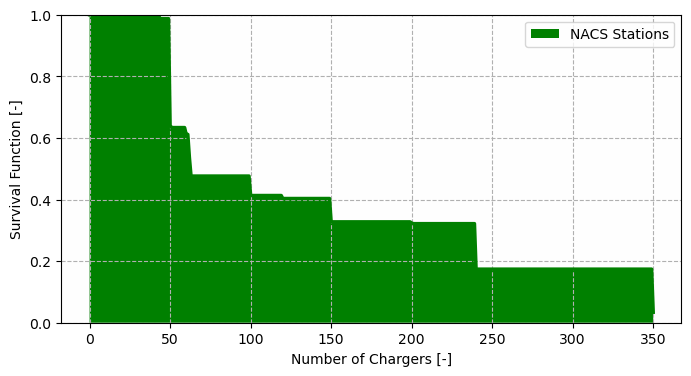

In [351]:
fig, ax = plt.subplots(figsize = (8, 4))

x = np.arange(0, 351, 1)
s = np.array(
    [n['power_kw'] for n in ccs_stations._node.values() for i in range(n['port_count'])]
    )
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'green',
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'green',
    # 'alpha': .5,
    'label': 'NACS Stations',
}

ax.fill_between(x, y, **kw)

x = np.arange(0, 81, 1)
s = np.array([n['port_count'] for n in ccs_stations._node.values()])
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'k',
}

# ax.plot(x, y, **kw)

kw = {
    'fc': 'k',
    # 'alpha': .5,
    'label': 'CCS Stations',
}

# ax.fill_between(x, y, **kw)

kw = {
    # 'xlim': (0, 80),
    'ylim': (0, 1),
    'xlabel': 'Number of Chargers [-]',
    'ylabel': 'Survival Function [-]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/stations_survival.png', bbox_inches = 'tight', dpi = 300
# )

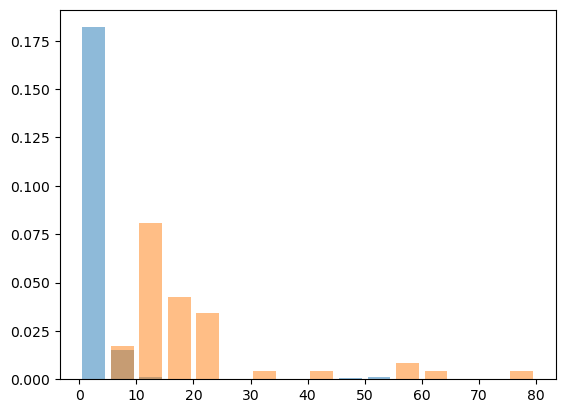

In [294]:
x = np.arange(0, 81, 5)
s_n = np.array([n['power_kw'] for n in nacs_stations._node.values()])
# y = np.array([sum(((s >= (xi - 5)) & (s < xi))) / len(s) for xi in x])

kw = {
    'bins': x,
    'density': True,
    'rwidth': .5,
}

# plt.hist(s, **kw)

x = np.arange(0, 81, 5)
s_c = np.array([n['power_kw'] for n in ccs_stations._node.values()])
# y = np.array([sum(((s >= (xi - 5)) & (s < xi))) / len(s) for xi in x])

kw = {
    'bins': x,
    'density': True,
    'rwidth': .8,
    'alpha': .5,
    # 'align': 'left',
}

_ = plt.hist(s_c, **kw)

kw = {
    'bins': x,
    'density': True,
    'rwidth': .8,
    'alpha': .5,
    # 'align': 'left',
}

_ = plt.hist(s_n, **kw)

In [130]:
'''
Loading results
'''

results = {}

results['All'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/all/summary_2.json', 'r')
)

results['NACS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/nacs/summary_2.json', 'r')
)

results['CCS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs/summary_2.json', 'r')
)

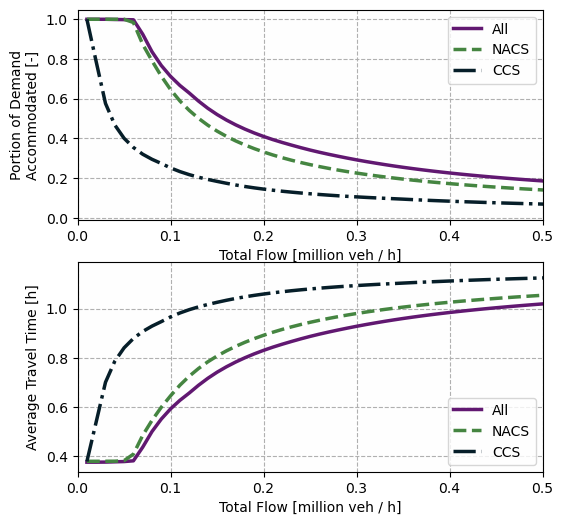

In [332]:
fig, ax = plt.subplots(2, 1, figsize = (6, 6))

# ax = [ax, ax.twinx()]

scales = np.arange(1e4, 1e6 + 1e4, 1e4)

max_cost = max([max(v['costs']) for v in results.values()])

colors = ["#1c4585", "#9b2ba1", "#1d8a20"]
colors = ["#4749dc", "#150c25", "#0a7fb2"]
colors = ["#061e29", "#458541", "#611871"]
linestyles = ['-.', '--', '-']

for k, v in results.items():

    kw = {
        'lw': 2.5,
        'ls': linestyles.pop(),
        'c': colors.pop(),
        'label': f'{k}',
    }
    
    ax[0].plot(scales / 1e6, 1 - np.array(v['ratios'][1:]), **kw)
    ax[1].plot(
        scales / 1e6, (np.array(v['costs'][1:])) / scales, **kw
    )

ax[0].set_ylabel('Portion of Demand\nAccommodated [-]')
ax[1].set_ylabel('Average Travel Time [h]')

kw = {
    'xlabel': 'Total Flow [million veh / h]',
    'facecolor': '#fefefe',
    'xlim': [0, .5],
    # 'xlim': (0, 1e5),
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

_ = [ax.legend() for ax in ax]

fig.savefig(
    'Paper/figures/esn_performance.png', bbox_inches = 'tight', dpi = 300
)

In [336]:
1e6 * 24 * 365, 2.6e9 / (24 * 365)

(8760000000.0, 296803.65296803653)

In [170]:
solution = nice.graph.graph_from_json(
    '/media/aaron/Extreme SSD/nice_results/nacs/run_100_2.json'
)

In [171]:
average_utilization = np.mean(
    [n['utilization'] for k, n in solution._node.items() if 'station' in k]
)
average_utilization

0.562364021756519

In [172]:
average_utilization = np.mean(
    [n['utilization'] > .9 for k, n in solution._node.items() if 'station' in k]
)
average_utilization

0.5957446808510638

In [164]:
solution._node['station_2170']

{'access_code': 'public',
 'access_days_time': "24 hours daily. Please check Tesla's online station map to see if an adapter is required at this location.",
 'open_date': '2022-08-24',
 'owner_type_code': 'P',
 'restricted_access': False,
 'status_code': 'E',
 'funding_sources': None,
 'facility_type': 'PARKING_LOT',
 'station_name': 'Countryside Plaza - Tesla Supercharger',
 'latitude': 37.50877,
 'longitude': -120.8761,
 'city': 'Turlock',
 'country': 'US',
 'state': 'CA',
 'street_address': '1680 Countryside Drive',
 'zip': '95380',
 'ev_workplace_charging': False,
 'network': 'Tesla',
 'charging_level': 'dc_fast',
 'connector': 'TESLA',
 'power_kw': 250.0,
 'port_count': 16,
 'x': -120.8761,
 'y': 37.50877,
 'power': 250000.0,
 'type': 'station',
 'volumes': [[0.0,
   0.025396825396825397,
   0.025714285714285714,
   0.026015037593984963,
   0.02631578947368421,
   0.02661654135338346,
   0.026917293233082704,
   0.027218045112781957,
   0.027518796992481203,
   0.02781954887218045

In [161]:
solution.nodes

NodeView(('San Buenaventura (Ventura), CA', 'Inglewood, CA', 'Santa Clarita, CA', 'Palmdale, CA', 'Oxnard, CA', 'Glendale, CA', 'Los Angeles, CA', 'Rancho Cucamonga, CA', 'San Jose, CA', 'San Francisco, CA', 'San Mateo, CA', 'Vallejo, CA', 'Riverside, CA', 'Moreno Valley, CA', 'Corona, CA', 'Sunnyvale, CA', 'Santa Clara, CA', 'Pomona, CA', 'West Covina, CA', 'Burbank, CA', 'Long Beach, CA', 'Lancaster, CA', 'Downey, CA', 'Chico, CA', 'Torrance, CA', 'Modesto, CA', 'Hayward, CA', 'Visalia, CA', 'Menifee, CA', 'Daly City, CA', 'Irvine, CA', 'Simi Valley, CA', 'Thousand Oaks, CA', 'Roseville, CA', 'Santa Rosa, CA', 'Temecula, CA', 'Huntington Beach, CA', 'Jurupa Valley, CA', 'Anaheim, CA', 'Costa Mesa, CA', 'Fullerton, CA', 'Garden Grove, CA', 'Orange, CA', 'Santa Ana, CA', 'Hesperia, CA', 'Stockton, CA', 'San Bernardino, CA', 'Victorville, CA', 'Bakersfield, CA', 'Fairfield, CA', 'Vacaville, CA', 'Escondido, CA', 'Oakland, CA', 'Chula Vista, CA', 'San Diego, CA', 'Richmond, CA', 'Ontario